In [219]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('titanic\\train.csv')
test_data = pd.read_csv('titanic\\test.csv')
combine = [train_data, test_data]

In [220]:
train_data.info()
train_data.describe()
train_data.describe(include=['O'])
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 对特征进行分析下

In [221]:
for col in ['Sex', 'Pclass','SibSp','Parch','Embarked']:
    print(train_data[[col,'Survived']].groupby([col], as_index=False).mean().sort_values(by='Survived', ascending=False))

      Sex  Survived
0  female  0.742038
1    male  0.188908
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


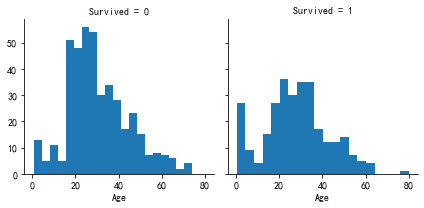

In [222]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

从上图可以看出，年纪大的和年纪小的存活率，船上成员集中年纪段在15-40，年龄作为特征维度训练， 但是年龄有177个缺失

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


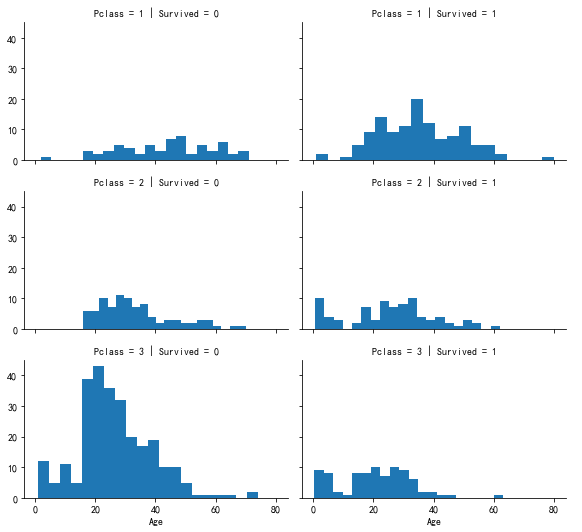

In [223]:
g = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.5, aspect=1.6)
g.map(plt.hist, 'Age', alpha=1, bins=20)
g.add_legend()

从上如可以看出，船舱等级值越小的的存活率越大，所以船舱等级也作为特征维度进行训练

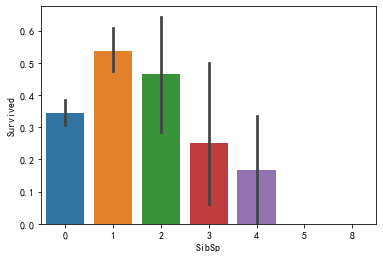

In [224]:
sns.barplot(x="SibSp", y="Survived", data=train_data)

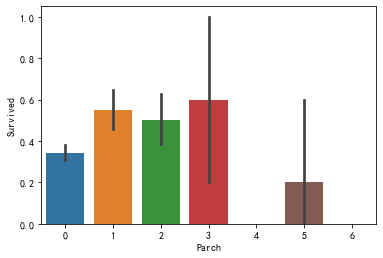

In [225]:
sns.barplot(x="Parch", y="Survived", data=train_data)

# 处理SibSp和Parch

对SibSp和Parch，新增FamilyLabel特征，先计算FamilySize=Parch+SibSp+1,根据FamilySize分成3类

In [226]:
for data_set in combine:
    data_set['FamilySize'] = data_set['SibSp']+data_set['Parch'] +1
    
train_data[['FamilySize','Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived',ascending=False)

for data_set in combine:
    data_set['FamilyLable'] = data_set['FamilySize'].apply(lambda x: 0 if x > 7 else 1 if x >4 or x == 1 else 2)

train_data = train_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_data, test_data]

# 处理Name

处理name获取，Title：不同称呼的乘客幸存率不同

In [227]:
for data_set in combine:
    data_set['Title'] = data_set['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])
pd.crosstab(test_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,0,1
Dr,1,0
Master,6,15
Miss,26,52
Mr,95,145
Mrs,31,41
Ms,1,0
Rev,0,2


In [228]:
for data_set in combine:
    data_set['Title'] = data_set['Title'].replace(['Capt','Col','Countess','Don','Dr','Jonkheer','Lady','Major','Rev','Sir','Dona'],'Rare')
    data_set['Title'] = data_set['Title'].replace('Mlle', 'Miss')
    data_set['Title'] = data_set['Title'].replace('Ms', 'Miss')
    data_set['Title'] = data_set['Title'].replace('Mme', 'Mrs')
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [229]:
train_data.head()
test_data.head()
train_data[['Title','Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
2,3,0.793651
1,2,0.702703
3,4,0.575000
4,5,0.347826
0,1,0.156673


In [230]:
for data_set in combine:
    data_set['Sex'] = data_set['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# 处理age

In [231]:
corr = train_data.corr()
corr

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilyLable,Title
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,0.012658,-0.026964,0.003878
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,0.257307,0.289087,0.407753
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,-0.549500,-0.236739,-0.173929
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.182333,0.245649,0.502713
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,0.096067,-0.064190,-0.104766
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,1.000000,0.179211,0.136310
FamilyLable,-0.026964,0.289087,-0.236739,0.245649,-0.064190,0.179211,1.000000,0.268630
Title,0.003878,0.407753,-0.173929,0.502713,-0.104766,0.136310,0.268630,1.000000


使用Sex,Pcalss,Title三个特征构建随机森林模型，填充年龄缺失值。

In [232]:
from sklearn.ensemble import RandomForestRegressor
age_df = pd.DataFrame()
for data_set in combine:
    age_df = age_df.append(data_set[['PassengerId', 'Age', 'Pclass', 'Sex', 'Title']])
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df['Age'].notnull()]
unknown_age = age_df[age_df['Age'].isnull()]
y = known_age.iloc[:, 1]
X = known_age.iloc[:, 2:]

rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age.iloc[:, 2:])
predictedAges
unknown_age['Age'] = predictedAges
passend_to_age = unknown_age.set_index('PassengerId')['Age'].to_dict()
passend_to_age

for data_set in combine:
    data_set['Age'] = data_set[['Age','PassengerId']].apply(lambda x: passend_to_age[x['PassengerId']] if x['PassengerId'] in  passend_to_age else x['Age'], axis=1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [233]:
for data_set in combine:
    data_set['Embarked'].fillna('S',inplace=True)
    data_set['Fare'].fillna(test_data['Fare'].mean(),inplace=True)
'''   
for data_set in combine:
    data_set.loc[ data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare']   = 2
    data_set.loc[ data_set['Fare'] > 31, 'Fare'] = 3
    data_set['Fare'] = data_set['Fare'].astype(int)
'''

combine = [train_data, test_data]

features = ['Pclass', 'Sex', 'Age', 'Title', 'Fare', 'Embarked', 'FamilyLable']
train_features = train_data[features]
train_labels = train_data['Survived']
test_features = test_data[features]
print('特征值')
dvec=DictVectorizer(sparse=False)
train_features=dvec.fit_transform(train_features.to_dict(orient='record'))
print(train_features[:,:10])
dvec.feature_names_

特征值
[[22.          0.          0.         ...  3.          0.
   1.        ]
 [38.          1.          0.         ...  1.          1.
   3.        ]
 [26.          0.          0.         ...  3.          1.
   2.        ]
 ...
 [17.33372951  0.          0.         ...  3.          1.
   2.        ]
 [26.          1.          0.         ...  1.          0.
   1.        ]
 [32.          0.          1.         ...  3.          0.
   1.        ]]


['Age',
 'Embarked=C',
 'Embarked=Q',
 'Embarked=S',
 'FamilyLable',
 'Fare',
 'Pclass',
 'Sex',
 'Title']

# 决策树

In [234]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
# 构造ID3决策树
clf = DecisionTreeClassifier(criterion='entropy')
# 决策树训练
clf.fit(train_features, train_labels)

test_features=dvec.transform(test_features.to_dict(orient='record'))
# 决策树预测
pred_labels = clf.predict(test_features)

# 得到决策树准确率(基于训练集)
acc_decision_tree = round(clf.score(train_features, train_labels), 6)
print(u'score准确率为 %.4lf' % acc_decision_tree)


# 使用K折交叉验证 统计决策树准确率
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(clf, train_features, train_labels, cv=10)))

score准确率为 0.9843
cross_val_score准确率为 0.7812


# tpop

In [235]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(train_features, train_labels)
print(tpot.score(train_features, train_labels))
tpot.export('tpot_iris_pipeline.py')


Generation 1 - Current best internal CV score: 0.8440085368150146
Generation 2 - Current best internal CV score: 0.8485029188374866
Generation 3 - Current best internal CV score: 0.8485029188374866
Generation 4 - Current best internal CV score: 0.8485029188374866
Generation 5 - Current best internal CV score: 0.8507312786391312
Best pipeline: RandomForestClassifier(RFE(CombineDFs(input_matrix, input_matrix), criterion=gini, max_features=0.55, n_estimators=100, step=0.6500000000000001), bootstrap=True, criterion=entropy, max_features=1.0, min_samples_leaf=2, min_samples_split=18, n_estimators=100)
0.8866442199775533


In [241]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(bootstrap=True, criterion='entropy', max_features=1.0, min_samples_leaf=2, min_samples_split=18, n_estimators=100)
rfc.fit(train_features,train_labels)
accuracy=rfc.score(train_features,train_labels)
print("accuracy:%s"%accuracy)
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(rfc, train_features, train_labels, cv=10)))
pred_labels = rfc.predict(test_features)

accuracy:0.8866442199775533
cross_val_score准确率为 0.8441


In [242]:
pd.DataFrame({'Survived':pred_labels}).to_csv('submit.csv')
